# Install and Import Dependencies

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time
from datetime import datetime

import os
import shutil
import zipfile

import pandas as pd
import numpy as np

import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from pycaret.regression import *

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, SGDRegressor

# Load data

The dataset for this project will be obtained through web scraping from the Mendeley Data website. Mendeley Data is a free and secure cloud-based communal repository that stores data, ensuring it is easy to share, access and cite.

This dataset accompanies the paper "Machine Learning Modeling of Horizontal Photovoltaics Using Weather and Location Data" submitted to the Journal of Renewable Energy. This file contains power output from horizontal photovoltaic panels located at 12 Northern hemisphere sites over 14 months.

## Web Crawling settings

In [2]:
# Configure Selenium to run
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")

# Initialize the browser
driver = webdriver.Chrome(options=options)

# Access Mendeley Data page
url = "https://data.mendeley.com/datasets/hfhwmn8w24/3"
driver.get(url)

# Accepting cookies
try:
    wait = WebDriverWait(driver, 10)  # 10 seconds sleep
    accept_cookies = wait.until(EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")))
    accept_cookies.click()
    print("Cookies accepted.")
except Exception as e:
    print("No cookie popup found or error while accepting cookies:", e)

# Waiting for Download button to become available
download_button = wait.until(EC.presence_of_element_located((By.ID, "download-all")))
download_button.click()

print("Click on Download button was successful.")

# Donwloading dataset
time.sleep(5)

# Closing the browser
driver.quit()

Cookies accepted.
Click on Download button was successful.


## Adjusting dataset directory

In [3]:
# Define the source and target directories
source_folder = os.path.join(os.path.expanduser("~"), "Downloads")
target_folder = r"C:\\Users\\guilh\\OneDrive\\Documents\\GitHub\\ml-regression-models\\solar-energy\\dataset"
target_file_name = "data.csv"

# Find the downloaded zip file by its original name
original_file_name = "hfhwmn8w24-3.zip"
source_file_path = os.path.join(source_folder, original_file_name)
unzipped_file_name = "Pasion et al dataset.csv"

# Check if the source zip file exists
if os.path.exists(source_file_path):
    # Ensure the target directory exists
    os.makedirs(target_folder, exist_ok=True)
    
    # Unzip the file
    with zipfile.ZipFile(source_file_path, 'r') as zip_ref:
        zip_ref.extractall(target_folder)

    # Rename the extracted file to the target name
    extracted_file_path = os.path.join(target_folder, unzipped_file_name)
    final_file_path = os.path.join(target_folder, target_file_name)
    if os.path.exists(extracted_file_path):
        os.rename(extracted_file_path, final_file_path)
        print(f"File unzipped and renamed to '{final_file_path}'.")
    else:
        print(f"Extracted file '{unzipped_file_name}' not found in the target folder.")

    # Optionally remove the original zip file
    os.remove(source_file_path)
    print(f"Original zip file '{source_file_path}' removed.")
else:
    print(f"Zip file '{original_file_name}' not found in the Downloads folder.")

File unzipped and renamed to 'C:\\Users\\guilh\\OneDrive\\Documents\\GitHub\\ml-regression-models\\solar-energy\\dataset\data.csv'.
Original zip file 'C:\Users\guilh\Downloads\hfhwmn8w24-3.zip' removed.


In [4]:
df = pd.read_csv('../solar-energy/dataset/data.csv', sep=',')
df.shape

(21045, 17)

# Descriptive Analysis

In [5]:
df.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

Analyzing the data type of each feature is important to determine whether the data is qualitative or quantitative. It can be observed that only the Date variable needs to be converted to the date format to facilitate exploratory analysis.

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [8]:
df.describe().astype(int)

,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
count,21045,21045,21045,21045,21045,21045,21045,21045,21045,21045,21045,21045,21045,21045
mean,1267,38,-108,798,-2147483648,6,12,37,29,12,10,9,925,515
std,167,6,16,770,45798457,2,1,23,12,7,6,1,85,301
min,1000,20,-156,1,-2147483648,1,10,0,-19,0,0,0,781,0
25%,1100,38,-117,2,-2147483648,4,11,17,21,6,6,10,845,140
50%,1300,38,-111,458,-2147483648,7,13,33,30,13,9,10,961,722
75%,1400,41,-104,1370,-2147483648,9,14,52,37,18,14,10,1008,722
max,1545,47,-80,1947,-2147483648,12,15,99,65,34,49,10,1029,722


In [9]:
df.describe(include=['O'])

,Location,Season
count,21045,21045
unique,12,4
top,Travis,Summer
freq,2746,8208


## NaN Analysis

In [10]:
df.isnull().sum()

Location         0
Date             0
Time             0
Latitude         0
Longitude        0
Altitude         0
YRMODAHRMI       0
Month            0
Hour             0
Season           0
Humidity         0
AmbientTemp      0
PolyPwr          0
Wind.Speed       0
Visibility       0
Pressure         0
Cloud.Ceiling    0
dtype: int64

## Duplicated values

In [11]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


# Exploratory Data Analysis

## Understanding the locations

In [12]:
df_locations = df[['Location','Altitude','Latitude','Longitude']].drop_duplicates()
df_locations

,Location,Altitude,Latitude,Longitude
0,Camp Murray,84,47.11,-122.57
1113,Grissom,239,40.67,-86.15
2600,Hill Weber,1370,41.15,-111.99
4984,JDMT,2,26.98,-80.11
6763,Kahului,2,20.89,-156.44
7704,Malmstrom,1043,47.52,-111.18
9221,March AFB,458,33.90,-117.26
11425,MNANG,246,44.89,-93.20
12205,Offutt,380,41.13,-95.75
13086,Peterson,1879,38.82,-104.71


In [13]:
# Figure size
f = folium.Figure(width=1200, height=600)

# Map settings
m = folium.Map(location=[df_locations['Latitude'].mean(), df_locations['Longitude'].mean()], 
               tiles='OpenStreetMap', 
               zoom_start=4.4).add_to(f)

# Marker clusters
marker_cluster = MarkerCluster().add_to(m)

# Adding markers
for index, row in df_locations.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(f"<b>Location:</b> {row['Location']}<br>"
               f"<b>Altitude:</b> {row['Altitude']} m"),
        tooltip=row['Location'],  # Tooltip exibido ao passar o mouse
        icon=folium.Icon(color='red', icon='info-sign')  # Ícone do marcador
    ).add_to(marker_cluster)

# Plot map
m

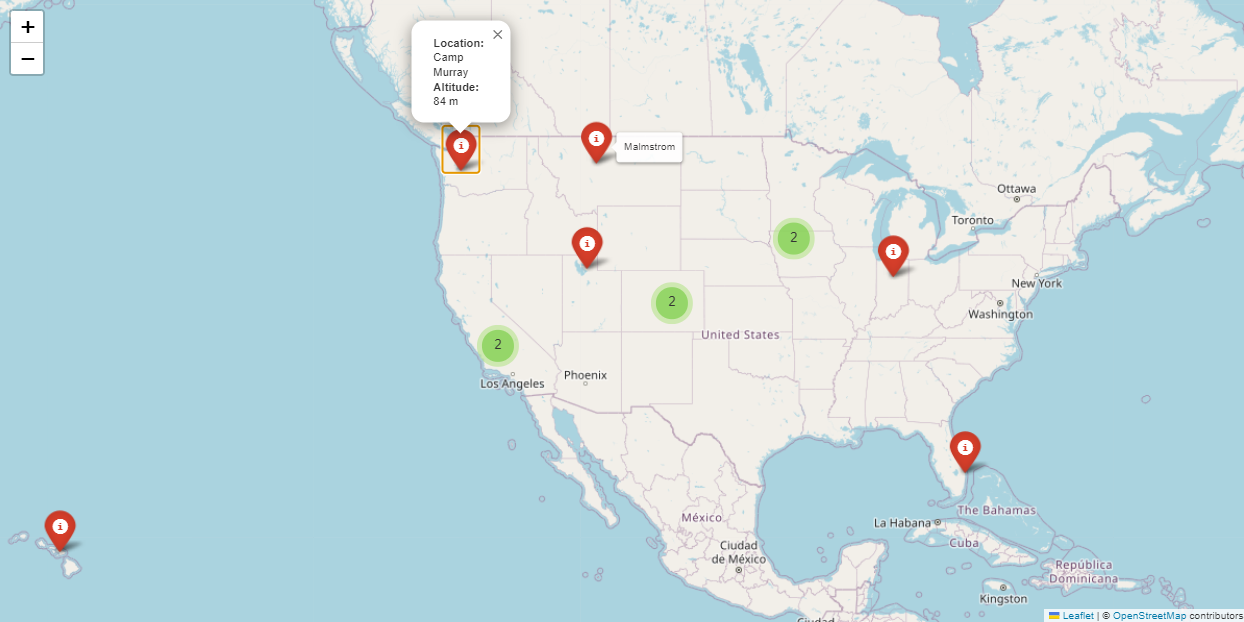

The location names like Camp Murray, Grissom, Hill Weber, Malmstrom, Peterson, Travis, Offutt, USAFA, and others are known U.S. military bases or sites, such as Malmstrom Air Force Base, Peterson Air Force Base, and USAFA (United States Air Force Academy), all of which are located in the U.S.

It is possible to confirm this information as the dataset is related to the Air Force Institute of Technology on the Data Mendeley website.

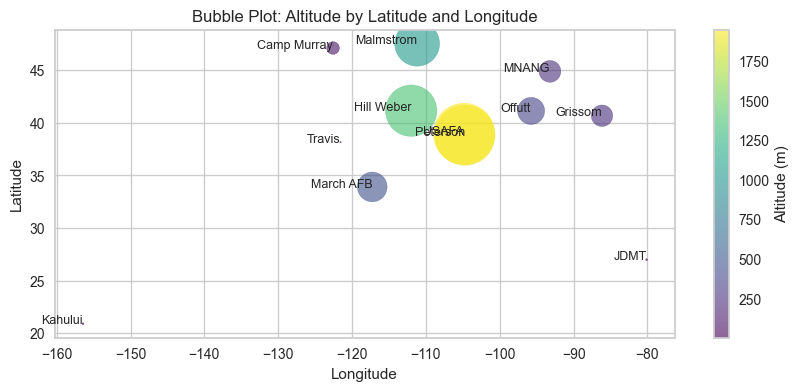

In [14]:
plt.figure(figsize=(10, 4))
plt.scatter(df_locations['Longitude'], df_locations['Latitude'], s=df_locations['Altitude'], alpha=0.6, c=df_locations['Altitude'], cmap='viridis')
plt.colorbar(label='Altitude (m)')
plt.title('Bubble Plot: Altitude by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Data labels
for i, row in df_locations.iterrows():
    plt.text(row['Longitude'], row['Latitude'], row['Location'], fontsize=9, ha='right')
    
plt.show()

The graph highlights that Camp Murray and Kahului are located near sea level, with altitudes of 84m and 2m, respectively. On the other hand, Hill Weber and Peterson stand out with higher altitudes of 1.370m and 1.879m, reflecting mountainous areas. Grissom, Malmstrom, and March AFB have intermediate altitudes, while JDMT and USAFA are among the lowest and highest locations on the graph.

## Seasonality

In [15]:
all_months = set(range(1, 13))

# Calculate missing months
missing_months = df.groupby('Location')['Month'].apply(lambda x: sorted(list(all_months - set(x)))).reset_index(name='Missing Months')

# Sort the dataframe by the length of the 'Missing Months' list in descending order
missing_months['Missing Months Count'] = missing_months['Missing Months'].apply(len)
missing_months_sorted = missing_months.sort_values(by='Missing Months Count', ascending=True)

# Drop the auxiliary column used for sorting
missing_months_sorted.drop(columns='Missing Months Count')

,Location,Missing Months
1,Grissom,[]
3,JDMT,[]
6,Malmstrom,[]
9,Peterson,[]
10,Travis,[]
0,Camp Murray,[11]
2,Hill Weber,[4]
7,March AFB,[2]
11,USAFA,[11]
5,MNANG,"[1, 6]"


Not all locations have a full year of data. This can affect the mean of Humidity, AmbientTemp, PolyPwr, and other variables for each location.

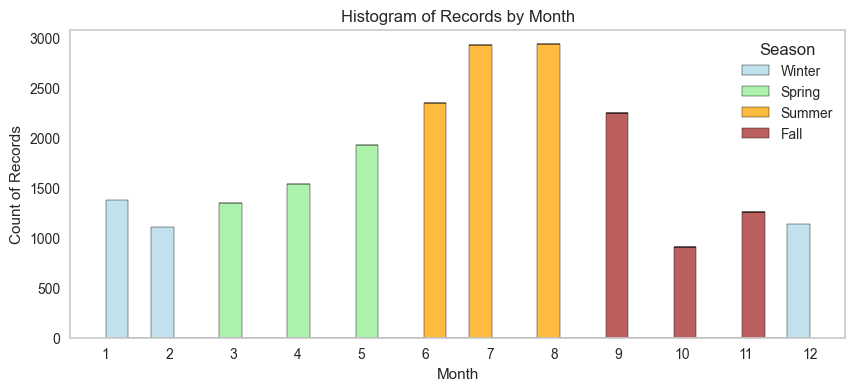

In [16]:
season_colors = {'Winter': 'lightblue',
                 'Spring': 'lightgreen',
                 'Summer': 'orange',
                 'Fall': 'brown'}

# Create a histogram of the count of records by Month
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Month', hue='Season', multiple="stack", palette=season_colors)

# Set labels and title
plt.title('Histogram of Records by Month')
plt.xlabel('Month')
plt.ylabel('Count of Records')

# Set the x-axis to show all months from 1 to 12
plt.xticks(range(1, 13))
plt.grid(False)

# Show the plot
plt.show()

Since the United States is in the Northern Hemisphere, Spring runs from March to May, Summer from June to August, Autumn from September to November, and Winter from December to February. It is important that the dataset contains consistent information for these periods in order to accurately predict solar energy output in this project.

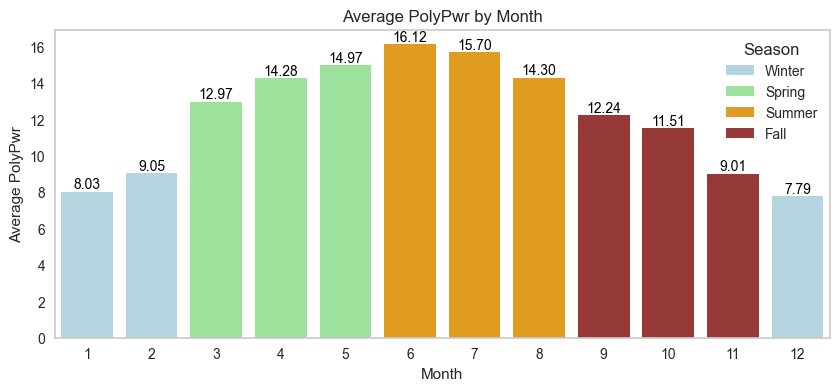

In [17]:
avg_poly_pwr = df.groupby(['Season','Month'])['PolyPwr'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 4))
ax = sns.barplot(x='Month', y='PolyPwr', hue='Season', data=avg_poly_pwr, palette=season_colors)

# Add data labels on the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{p.get_height():.2f}',  # Format the label
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label
                    ha='center', va='center',  # Center the label
                    fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')  # Adjust label position

# Set labels and title
plt.title('Average PolyPwr by Month')
plt.xlabel('Month')
plt.ylabel('Average PolyPwr')
plt.grid(False)
# Show the plot
plt.show()

The highest energy production occurs during the summer months (June, July, and August), which is expected as solar radiation tends to be more intense during these months. This could be due to higher ambient temperature, more sunlight hours, and less cloud cover in certain regions.
In winter (January and December), energy production is lower, which is characteristic due to less sunlight exposure, lower temperatures, and increased cloud cover.

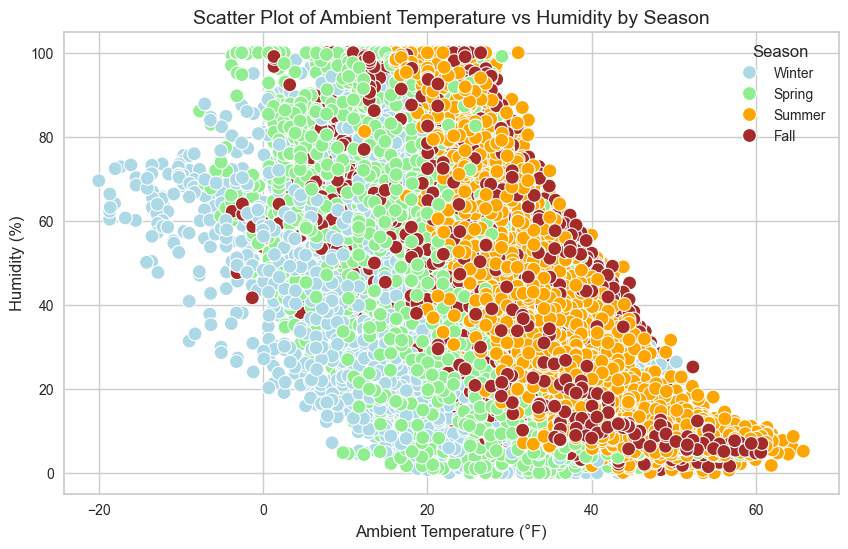

In [18]:
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(x='AmbientTemp', y='Humidity', hue='Season', data=df, palette=season_colors, s=100)

# Labels
plt.title('Scatter Plot of Ambient Temperature vs Humidity by Season', fontsize=14)
plt.xlabel('Ambient Temperature (°F)', fontsize=12)
plt.ylabel('Humidity (%)', fontsize=12)

# Legend
plt.legend(title='Season')

plt.show()

Humidity and ambient temperature can affect the efficiency of photovoltaic panels. Efficiency tends to decrease when humidity or temperature is high, as this can reduce the amount of direct sunlight hitting the panels.

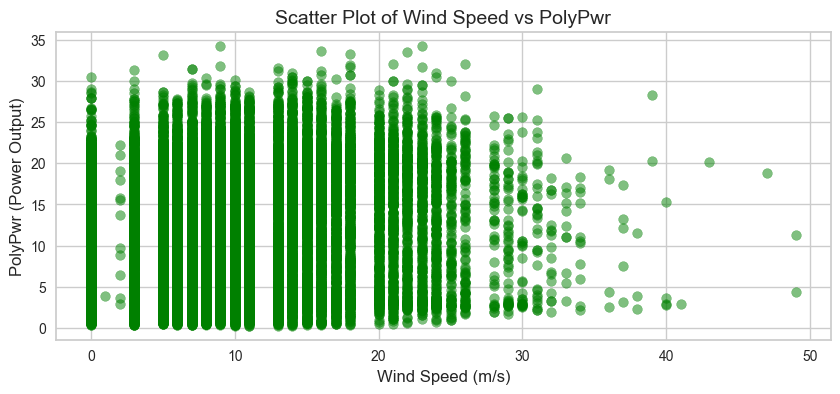

In [19]:
plt.figure(figsize=(10, 4))

# Scatter plot
plt.scatter(df['Wind.Speed'], df['PolyPwr'], alpha=0.5, color='green')

# Labels
plt.title('Scatter Plot of Wind Speed vs PolyPwr', fontsize=14)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('PolyPwr (Power Output)', fontsize=12)

plt.show()

The fact that many points are clustered suggests that other variables, such as ambient temperature, humidity or cloud cover, may be more determining in solar energy production than wind speed. But is important to notice that wind speed in daily life can vary significantly depending on the location and weather conditions, but generally, a "normal" or common wind speed in urban or rural areas is around 10 to 20 km/h. This speed is often associated with light to moderate winds.

## Correlation

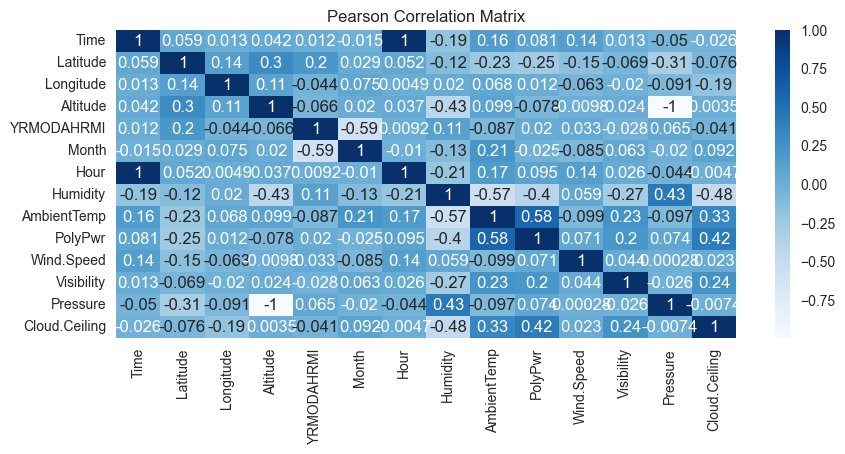

In [20]:
plt.figure(figsize=(10, 4))

sns.heatmap(df.corr(), annot=True, cmap='Blues')

plt.title("Pearson Correlation Matrix")

plt.show()

## Deleting unecessary columns

In [21]:
df = df.drop(columns=['Location','YRMODAHRMI','Time','Date'])

# Baseline model with Pycaret

## Setup

In [22]:
s = setup(data=df,
          target='PolyPwr',
          remove_outliers=True,
          session_id=123)

,Description,Value
0,Session id,123
1,Target,PolyPwr
2,Target type,Regression
3,Original data shape,"(21045, 13)"
4,Transformed data shape,"(20308, 16)"
5,Transformed train set shape,"(13994, 16)"
6,Transformed test set shape,"(6314, 16)"
7,Numeric features,11
8,Categorical features,1
9,Preprocess,True


In [23]:
best_model = compare_models(sort='mse', errors= 'raise')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.8827,17.4151,4.1724,0.6572,0.4202,0.5204,0.2440
rf,Random Forest Regressor,2.8768,17.9177,4.2326,0.6473,0.4226,0.5251,1.1780
et,Extra Trees Regressor,2.8478,18.4317,4.2924,0.6371,0.4215,0.5110,0.7000
xgboost,Extreme Gradient Boosting,2.9435,18.5018,4.3009,0.6359,0.4342,0.5223,0.1560
gbr,Gradient Boosting Regressor,3.1561,18.9600,4.3538,0.6268,0.4466,0.5668,0.4760
knn,K Neighbors Regressor,3.4672,23.6676,4.8625,0.5342,0.4720,0.6020,0.1170
br,Bayesian Ridge,3.9750,26.0773,5.1064,0.4868,0.5174,0.7123,0.0990
ridge,Ridge Regression,3.9748,26.0860,5.1072,0.4866,0.5176,0.7123,0.0960
lr,Linear Regression,3.9748,26.0863,5.1073,0.4866,0.5176,0.7123,0.8950
en,Elastic Net,4.1440,27.5126,5.2448,0.4586,0.5304,0.7532,0.1210


In [24]:
print(best_model)

LGBMRegressor(n_jobs=-1, random_state=123)


## Tunning best model

In [25]:
model_pycaret_lgbm_tuned = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9278,18.0919,4.2535,0.6478,0.4189,0.4854
1,2.8868,17.7693,4.2154,0.6451,0.4306,0.5785
2,2.8155,16.9442,4.1163,0.6667,0.4099,0.4496
3,2.7988,16.0014,4.0002,0.6996,0.4251,0.5709
4,2.8650,16.7557,4.0934,0.6662,0.4126,0.5055
5,2.9077,17.0970,4.1349,0.6586,0.4276,0.5717
6,2.9263,17.9804,4.2403,0.6581,0.4231,0.4943
7,2.7889,16.0983,4.0123,0.6714,0.4070,0.4763
8,2.8962,18.3332,4.2817,0.6408,0.4349,0.5673


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [26]:
model_pycaret_lgbm_tuned.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 66,
 'min_child_weight': 0.001,
 'min_split_gain': 0.4,
 'n_estimators': 90,
 'n_jobs': -1,
 'num_leaves': 90,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0005,
 'reg_lambda': 0.1,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_fraction': 0.5,
 'bagging_freq': 6,
 'bagging_fraction': 0.7}

## Evaluation best model

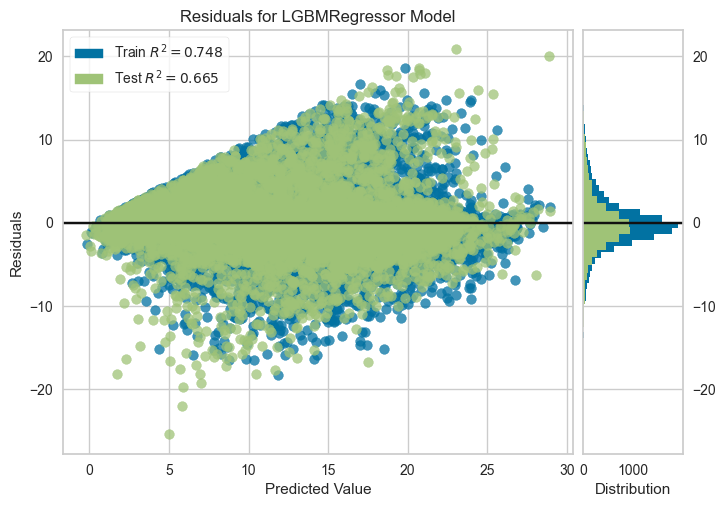

In [27]:
plot_model(model_pycaret_lgbm_tuned)

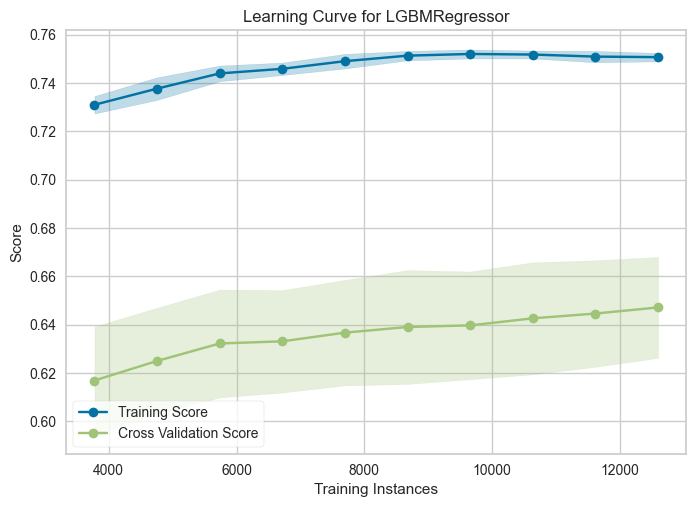

In [28]:
plot_model(model_pycaret_lgbm_tuned, plot='learning')

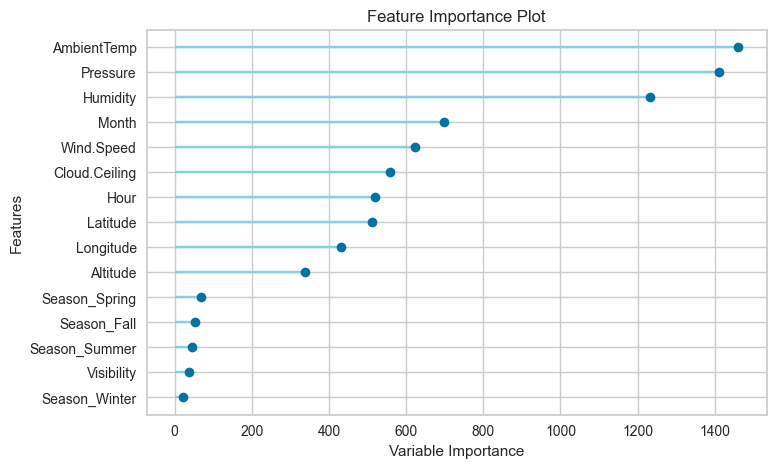

In [29]:
plot_model(model_pycaret_lgbm_tuned, plot='feature_all')

## Save model

In [30]:
final_model = finalize_model(model_pycaret_lgbm_tuned)
save_model(final_model, 'deploy-streamlit/solar_energy_pycaret_lgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Latitude', 'Longitude',
                                              'Altitude', 'Month', 'Hour',
                                              'Humidity', 'AmbientTemp',
                                              'Wind.Speed', 'Visibility',
                                              'Pressure', 'Cloud.Ceiling'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Season'],
                                     transformer=SimpleImputer(strategy='m...
                  TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  LGBMRegressor(bagging_fraction=0.7, bagging_freq=6,
    

In [31]:
pred_model_pycaret_lgbm_tuned = predict_model(model_pycaret_lgbm_tuned)
pred_models = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.7992,16.8861,4.1093,0.6653,0.4146,0.4950


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


# Feature Engineering

## Train test split

In [32]:
df_train_test = df.sample(frac= 0.95, random_state=42)
df_validate = df.drop(df_train_test.index)

df_train_test.reset_index(drop=True, inplace= True)
df_validate.reset_index(drop=True, inplace= True)

print('95% of data for modeling:', df_train_test.shape)
print('05% of data for validate:', df_validate.shape)

95% of data for modeling: (19993, 13)
05% of data for validate: (1052, 13)


In [33]:
X = df_train_test.drop(columns=['PolyPwr'])
y = df_train_test['PolyPwr']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15994, 12)
(15994,)
(3999, 12)
(3999,)


## Encoding

Season variable is nominal categorical

In [35]:
X_train = pd.get_dummies(data=X_train, columns=['Season'], drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=['Season'], drop_first=True)

## Normalization

In [36]:
sc = StandardScaler()

## SGD Regressor

LinearRegression always uses the least-squares as a loss function. For SGDRegressor you can specify a loss function and it uses Stochastic Gradient Descent (SGD) to fit.

In [37]:
sgd = SGDRegressor(loss='squared_loss',
                   penalty= 'l2',
                   alpha = 0.01,
                   max_iter = 4500,
                   learning_rate = "optimal",
                   eta0 = 0.01)

In [38]:
pipe_sgd = Pipeline([('scaler', StandardScaler()), ('sgd', sgd)])

In [39]:
loss = ['squared_loss','huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'] 
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 
eta0 = [1, 10, 100]
average = [True, False]

grid_sgd = {'sgd__loss':loss,
           'sgd__penalty':penalty,
           'sgd__alpha':alpha,
           'sgd__learning_rate':learning_rate,
           'sgd__average':average,
           'sgd__eta0':eta0} 

In [40]:
randsearch_sgd = RandomizedSearchCV(estimator=pipe_sgd, param_distributions=grid_sgd, 
                                 n_iter=1000, cv=3, verbose=2, n_jobs=-1)

In [41]:
#%%time

#rcv_sgd.fit(X_train, y_train)

## Random Forest

# Save validation dataset

In [42]:
df_validate.to_csv('deploy-streamlit/Xtest.csv', index=False)